In [170]:
import pandas as pd
import os

# LOAD AND PREPARE THE DATA

**Definitions of every column**

Season	Match Season  
DateTime	Match Date and Time (yyyy-mm-dd hh:mm:ss)  
HomeTeam	Home Team  
AwayTeam	Away Team  
FTHG	Full Time Home Team Goals  
FTAG	Full Time Away Team Goals  
FTR	Full Time Result (H=Home Win, D=Draw, A=Away Win)  
HTHG	Half Time Home Team Goals  
HTAG	Half Time Away Team Goals  
HTR	Half Time Result (H=Home Win, D=Draw, A=Away Win)  
Referee	Match Referee  
HS	Home Team Shots  
AS	Away Team Shots  
HST	Home Team Shots on Target  
AST	Away Team Shots on Target  
HC	Home Team Corners  
AC	Away Team Corners  
HF	Home Team Fouls Committed  
AF	Away Team Fouls Committed  
HY	Home Team Yellow Cards  
AY	Away Team Yellow Cards  
HR	Home Team Red Cards  
AR	Away Team Red Cards  

In [171]:
# df = pd.read_csv('results.csv', encoding='latin-1')  

# df_22_23 = pd.read_csv('22_23.csv')
# df_22_23['Season'] = '2022-23'
# df_23_24 = pd.read_csv('23_24.csv')
# df_23_24['Season'] = '2023-24'
# df_24_25 = pd.read_csv('24_25.csv')
# df_24_25['Season'] = '2024-25'
# df_25_current = pd.read_csv('25.csv')
# df_25_current['Season'] = '2025-26'

# df_all = pd.concat([df, df_22_23, df_23_24, df_24_25, df_25_current], sort=False)

# df_new_combined = pd.concat([df_22_23, df_23_24, df_24_25, df_25_current], sort=False)

# # FIX: Convert new dates (European format DD/MM/YYYY)
# # We map to 'DateTime' to match the old dataframe
# df_new_combined['DateTime'] = pd.to_datetime(df_new_combined['Date'], dayfirst=True, errors='coerce')

## Overall shape/specification/details

In [172]:
import pandas as pd
import numpy as np

print("=== STEP 1: LOADING & STANDARDIZING ===")

# 1. Load OLD Data
try:
    df_old = pd.read_csv('results.csv', encoding='latin-1')
    # FIX A: Convert Old Data Dates immediately
    # We don't use dayfirst=True here because ISO format (YYYY-MM-DD) is standard
    df_old['DateTime'] = pd.to_datetime(df_old['DateTime'], errors='coerce', utc=True)
    print(f"Old Data: {len(df_old)} rows")
except FileNotFoundError:
    df_old = pd.DataFrame()

# 2. Load NEW Data
new_files = {
    '2022-23': '22_23.csv',
    '2023-24': '23_24.csv', 
    '2024-25': '24_25.csv',
    '2025-26': '25.csv'
}

dfs_new = []

for season, filename in new_files.items():
    try:
        current_df = pd.read_csv(filename, encoding='latin-1')
        current_df['Season'] = season
        
        # Strip whitespace from column names
        current_df.columns = current_df.columns.str.strip()
        
        # --- FIX B: COMBINE AND CONVERT IMMEDIATELY ---
        if 'Date' in current_df.columns and 'Time' in current_df.columns:
            # 1. Create the string
            current_df['DateTime_Str'] = current_df['Date'].astype(str) + ' ' + current_df['Time'].astype(str)
            
            # 2. Convert to datetime object RIGHT NOW using dayfirst=True
            current_df['DateTime'] = pd.to_datetime(current_df['DateTime_Str'], dayfirst=True, errors='coerce', utc=True)
            
            # Drop the temp string column
            current_df = current_df.drop(columns=['DateTime_Str'])
            
            print(f"Loaded {filename}: {len(current_df)} rows. (Parsed Date+Time)")
            
        elif 'Date' in current_df.columns:
            # Fallback: Just Date
            current_df['DateTime'] = pd.to_datetime(current_df['Date'], dayfirst=True, errors='coerce', utc=True)
            print(f"Loaded {filename}: {len(current_df)} rows. (Parsed Date only)")
            
        else:
            print(f"WARNING: No Date column found in {filename}")
            continue

        # Check if we lost data during conversion
        invalid_dates = current_df['DateTime'].isnull().sum()
        if invalid_dates > 0:
             print(f"  -> WARNING: {invalid_dates} rows have invalid dates in {filename}")

        dfs_new.append(current_df)
            
    except Exception as e:
        print(f"Could not load {filename}: {e}")

# 3. Combine New Data
if dfs_new:
    df_new_combined = pd.concat(dfs_new, sort=False)
else:
    df_new_combined = pd.DataFrame()

# 4. Merge Everything
# Now both DataFrames already have 'DateTime' as real datetime objects.
# We don't need to parse them again.
df_all = pd.concat([df_old, df_new_combined], sort=False)

print("\n=== STEP 2: CLEANING ===")

# 6. Clean up
missing = df_all['DateTime'].isnull().sum()
if missing > 0:
    print(f"Dropping {missing} rows with invalid dates...")

df_filtered = df_all.dropna(subset=['DateTime']).copy()

# 7. Standardize Team Names
team_name_map = {
    'Man Utd': 'Man United',
    'Manchester United': 'Man United',
    'Nott\'m Forest': 'Nottm Forest',
    'Sheffield United': 'Sheffield United',
    'Luton Town': 'Luton',
    'Ipswich Town': 'Ipswich'
}
df_filtered['HomeTeam'] = df_filtered['HomeTeam'].replace(team_name_map)
df_filtered['AwayTeam'] = df_filtered['AwayTeam'].replace(team_name_map)
print(df_filtered['DateTime'].head(5))

# 8. Sort
df_filtered = df_filtered.sort_values('DateTime').reset_index(drop=True)

# Optional: Ensure FTHG is numeric before dropping NaNs (sometimes strings like 'A' get in)
df_filtered['FTHG'] = pd.to_numeric(df_filtered['FTHG'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['FTHG']) 

print("\n=== FINAL STATUS ===")
print(f"Total Matches: {len(df_filtered)}")
if not df_filtered.empty:
    print(f"Date Range: {df_filtered['DateTime'].min()} to {df_filtered['DateTime'].max()}")
    print("\nNewest Matches:")
    print(df_filtered[['DateTime', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']].tail(5))
else:
    print("DataFrame is empty! Check input files.")

=== STEP 1: LOADING & STANDARDIZING ===
Old Data: 11113 rows
Loaded 22_23.csv: 380 rows. (Parsed Date+Time)
Loaded 23_24.csv: 380 rows. (Parsed Date+Time)
Loaded 24_25.csv: 380 rows. (Parsed Date+Time)
Loaded 25.csv: 160 rows. (Parsed Date+Time)

=== STEP 2: CLEANING ===
0   1993-08-14 00:00:00+00:00
1   1993-08-14 00:00:00+00:00
2   1993-08-14 00:00:00+00:00
3   1993-08-14 00:00:00+00:00
4   1993-08-14 00:00:00+00:00
Name: DateTime, dtype: datetime64[ns, UTC]

=== FINAL STATUS ===
Total Matches: 12413
Date Range: 1993-08-14 00:00:00+00:00 to 2025-12-15 20:00:00+00:00

Newest Matches:
                       DateTime        HomeTeam     AwayTeam  FTHG  FTAG
12408 2025-12-14 14:00:00+00:00      Sunderland    Newcastle     1     0
12409 2025-12-14 14:00:00+00:00  Crystal Palace     Man City     0     3
12410 2025-12-14 14:00:00+00:00        West Ham  Aston Villa     2     3
12411 2025-12-14 16:30:00+00:00       Brentford        Leeds     1     1
12412 2025-12-15 20:00:00+00:00      Man Un

## Conclusion

We can observe that a lot of important data from seasons before 2000 is not available, so we have to cut out these seasons, because we will use more specific statistics than just the score. 

In [173]:
# Filter for seasons 2000 onwards
df_filtered = df_all[df_all['Season'] >= '2000-01'].copy()

print(f"Original dataset: {len(df)} matches")
print(f"Filtered dataset (2000+): {len(df_filtered)} matches")
print(f"\nSeasons included: {sorted(df_filtered['Season'].unique())}")

# Check missing values in filtered data
print("\nMissing values in filtered data:")
print(df_filtered.isnull().sum())

# Check data completeness
print(f"\nPercentage of missing values per column:")
print((df_filtered.isnull().sum() / len(df_filtered) * 100).round(2))

# Basic statistics
print(f"\nBasic stats:")
print(f"Total matches: {len(df_filtered)}")
print(f"Unique teams: {len(set(df_filtered['HomeTeam'].unique()) | set(df_filtered['AwayTeam'].unique()))}")
print(f"\nResult distribution:")
print(df_filtered['FTR'].value_counts())
print(f"\nResult percentages:")
print(df_filtered['FTR'].value_counts(normalize=True) * 100)

Original dataset: 11113 matches
Filtered dataset (2000+): 9589 matches

Seasons included: ['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25', '2025-26']

Missing values in filtered data:
Season         0
DateTime       0
HomeTeam       0
AwayTeam       0
FTHG           0
            ... 
CLCD        9429
CLCA        9429
LBCH        9429
LBCD        9429
LBCA        9429
Length: 165, dtype: int64

Percentage of missing values per column:
Season       0.00
DateTime     0.00
HomeTeam     0.00
AwayTeam     0.00
FTHG         0.00
            ...  
CLCD        98.33
CLCA        98.33
LBCH        98.33
LBCD        98.33
LBCA        98.33
Length: 165, dtype: float64

Basic stats:
Total matches: 9589
Unique teams: 46

Result distribution:
FTR
H    4395
A    2829
D    2365
N

Perfect! Now we have the optimal dataset for the model, next we have to prepare it.

In [174]:
df_filtered['DateTime'] = pd.to_datetime(df_filtered['DateTime'])

df_filtered = df_filtered.sort_values('DateTime').reset_index(drop=True)

df_filtered['Year'] = df_filtered['DateTime'].dt.year
df_filtered['Month'] = df_filtered['DateTime'].dt.month
df_filtered['DayOfWeek'] = df_filtered['DateTime'].dt.dayofweek

print("Data prepared! Shape:", df_filtered.shape)
print(df_filtered[['DateTime', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']].tail(10))

Data prepared! Shape: (9589, 168)
                      DateTime        HomeTeam     AwayTeam  FTHG  FTAG FTR
9579 2025-12-13 15:00:00+00:00         Chelsea      Everton     2     0   H
9580 2025-12-13 15:00:00+00:00       Liverpool     Brighton     2     0   H
9581 2025-12-13 17:30:00+00:00         Burnley       Fulham     2     3   A
9582 2025-12-13 20:00:00+00:00         Arsenal       Wolves     2     1   H
9583 2025-12-14 14:00:00+00:00   Nott'm Forest    Tottenham     3     0   H
9584 2025-12-14 14:00:00+00:00      Sunderland    Newcastle     1     0   H
9585 2025-12-14 14:00:00+00:00  Crystal Palace     Man City     0     3   A
9586 2025-12-14 14:00:00+00:00        West Ham  Aston Villa     2     3   A
9587 2025-12-14 16:30:00+00:00       Brentford        Leeds     1     1   D
9588 2025-12-15 20:00:00+00:00      Man United  Bournemouth     4     4   D


# Model

We need to calculate team strength (elo, like in chess) based on past matches

To do that we need to create a function that adds more columns/informations do our dataset based on the matches

In [175]:
def calculate_team_form(df, n_matches=5):

    df_with_features = df.copy()

    # Initialize feature columns
    features_to_add = [
        'home_wins_last_5', 'home_draws_last_5', 'home_losses_last_5',
        'away_wins_last_5', 'away_draws_last_5', 'away_losses_last_5',
        'home_goals_scored_avg', 'home_goals_conceded_avg',
        'away_goals_scored_avg', 'away_goals_conceded_avg',
        'home_points_last_5', 'away_points_last_5'
    ]
    
    for feature in features_to_add:
        df_with_features[feature] = 0.0

    for idx in range(len(df_with_features)):
        if idx % 500 == 0:
            print(f"Processing match {idx}/{len(df_with_features)}")
        
        current_match = df_with_features.iloc[idx]
        home_team = current_match["HomeTeam"]
        away_team = current_match["AwayTeam"]
        current_date = current_match["DateTime"]

        prev_matches = df_with_features[df_with_features['DateTime'] < current_date]

        if len(prev_matches) == 0:
            continue

        home_prev = prev_matches[
            (prev_matches['HomeTeam'] == home_team) |
            (prev_matches['AwayTeam'] == home_team)
        ].tail(n_matches)

        if len(home_prev) > 0:
            home_team_wins = 0
            home_team_draws = 0
            home_team_losses = 0
            home_team_goals_scored = []
            home_team_goals_conceded = []

            for _, match in home_prev.iterrows():
                if match['HomeTeam'] == home_team:
                    # Home team was playing at home
                    goals_scored = match['FTHG']
                    goals_conceded = match['FTAG']
                    result = match['FTR']

                    if result == 'H':
                        home_team_wins += 1
                    elif result == 'D':
                        home_team_draws += 1
                    else:
                        home_team_losses += 1
                
                else:
                    # Home team was playing away
                    goals_scored = match['FTAG']
                    goals_conceded = match['FTHG']
                    result = match['FTR']

                    if result == 'A':
                        home_team_wins += 1
                    elif result == 'D':
                        home_team_draws += 1
                    else:
                        home_team_losses += 1

                home_team_goals_scored.append(goals_scored)
                home_team_goals_conceded.append(goals_conceded)
            
            # Store gained data 
            df_with_features.at[idx, 'home_wins_last_5'] = home_team_wins
            df_with_features.at[idx, 'home_losses_last_5'] = home_team_losses
            df_with_features.at[idx, 'home_draws_last_5'] = home_team_draws
            df_with_features.at[idx, 'home_goals_scored_avg'] = sum(home_team_goals_scored)/len(home_team_goals_scored)
            df_with_features.at[idx, 'home_goals_conceded_avg'] = sum(home_team_goals_conceded)/len(home_team_goals_conceded)
            df_with_features.at[idx, 'home_points_last_5'] = home_team_wins*3 + home_team_draws



        away_prev = prev_matches[
            (prev_matches['HomeTeam'] == away_team) |
            (prev_matches['AwayTeam'] == away_team)
        ].tail(n_matches)


        if len(away_prev) > 0:
            away_team_wins = 0
            away_team_draws = 0
            away_team_losses = 0
            away_team_goals_scored = []
            away_team_goals_conceded = []
            
            for _, match in away_prev.iterrows():
                if match['HomeTeam'] == away_team:
                    goals_scored = match['FTHG']
                    goals_conceded = match['FTAG']
                    result = match['FTR']
                    
                    if result == 'H':
                        away_team_wins += 1
                    elif result == 'D':
                        away_team_draws += 1
                    else:
                        away_team_losses += 1
                else:
                    goals_scored = match['FTAG']
                    goals_conceded = match['FTHG']
                    result = match['FTR']
                    
                    if result == 'A':
                        away_team_wins += 1
                    elif result == 'D':
                        away_team_draws += 1
                    else:
                        away_team_losses += 1
                
                away_team_goals_scored.append(goals_scored)
                away_team_goals_conceded.append(goals_conceded)
            
            # Store away team features
            df_with_features.at[idx, 'away_wins_last_5'] = away_team_wins
            df_with_features.at[idx, 'away_draws_last_5'] = away_team_draws
            df_with_features.at[idx, 'away_losses_last_5'] = away_team_losses
            df_with_features.at[idx, 'away_goals_scored_avg'] = sum(away_team_goals_scored) / len(away_team_goals_scored)
            df_with_features.at[idx, 'away_goals_conceded_avg'] = sum(away_team_goals_conceded) / len(away_team_goals_conceded)
            df_with_features.at[idx, 'away_points_last_5'] = away_team_wins * 3 + away_team_draws
    
    print("Feature engineering complete!")
    return df_with_features

## Feature Engineering Function

This function calculates rolling team performance statistics based on their last N matches. For each match in the dataset, it looks back at historical data (only matches that occurred before the current match) and computes form indicators for both the home and away teams.

### Features Calculated (per team):
- **Wins/Draws/Losses**: Count of results in last 5 matches
- **Points**: Total points earned (3 for win, 1 for draw, 0 for loss)
- **Goals Scored Average**: Mean goals scored per match
- **Goals Conceded Average**: Mean goals conceded per match

### Key Implementation Details:
- **No lookahead bias**: Only uses data from matches that occurred before the current match date
- **Handles both home and away**: Tracks team performance regardless of venue
- **Flexible window**: Can adjust `n_matches` parameter (default is 5 matches)
- **Skips early matches**: Matches without sufficient history are left with default values (0.0)

### Parameters:
- `df`: DataFrame containing match results with columns: DateTime, HomeTeam, AwayTeam, FTHG, FTAG, FTR
- `n_matches`: Number of previous matches to consider for rolling statistics (default: 5)

### Returns:
DataFrame with original columns plus 12 new feature columns (6 for home team, 6 for away team)

### Usage:
```python
df_features = calculate_team_form(df_filtered, n_matches=5)
```

### Note:
This function can take several minutes to run on large datasets as it processes each match sequentially to maintain temporal integrity.

In [176]:
def calculate_elo_ratings(df, k_factor=20):
    all_teams = set(df['HomeTeam'].unique()) | set(df['AwayTeam'].unique())

    elo_ratings = {team: 1500 for team in all_teams}
    df['HomeElo'] = 0.0
    df['AwayElo'] = 0.0

    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        result = row['FTR']

        current_home_elo = elo_ratings[home_team]
        current_away_elo = elo_ratings[away_team]

        df.at[index, 'HomeElo'] = current_home_elo
        df.at[index, 'AwayElo'] = current_away_elo

        expected_home_win_prob = 1 / (1 + 10**((current_away_elo - current_home_elo) / 400))

        if result == 'H':
            actual_score_home = 1
        elif result == 'D':
            actual_score_home = 0.5
        else:
            actual_score_home = 0

        
        new_home_elo = current_home_elo + k_factor * (actual_score_home - expected_home_win_prob)
        new_away_elo = current_away_elo + k_factor * ((1-actual_score_home) - (1 - expected_home_win_prob))

        elo_ratings[home_team] = new_home_elo
        elo_ratings[away_team] = new_away_elo
    return df


df_filtered = calculate_elo_ratings(df_filtered)

print(df_filtered[['DateTime', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo']].tail())


                      DateTime        HomeTeam     AwayTeam      HomeElo  \
9584 2025-12-14 14:00:00+00:00      Sunderland    Newcastle  1496.621487   
9585 2025-12-14 14:00:00+00:00  Crystal Palace     Man City  1642.345651   
9586 2025-12-14 14:00:00+00:00        West Ham  Aston Villa  1517.689878   
9587 2025-12-14 16:30:00+00:00       Brentford        Leeds  1581.132378   
9588 2025-12-15 20:00:00+00:00      Man United  Bournemouth  1597.842829   

          AwayElo  
9584  1646.040781  
9585  1766.709969  
9586  1703.658805  
9587  1476.120788  
9588  1582.729255  


In [177]:
df_features = calculate_team_form(df_filtered, n_matches=5)

# Check if any features are non-zero
# print("\nSum of home_points_last_5:", df_features['home_points_last_5'].sum())
# print("Max of home_points_last_5:", df_features['home_points_last_5'].max())

print("\n Features created:")
print(df_features[['HomeTeam', 'AwayTeam', 'FTR', 'home_points_last_5', 
                    'away_points_last_5', 'home_goals_scored_avg', 
                    'away_goals_scored_avg']].tail(20))

Processing match 0/9589
Processing match 500/9589
Processing match 1000/9589
Processing match 1500/9589
Processing match 2000/9589
Processing match 2500/9589
Processing match 3000/9589
Processing match 3500/9589
Processing match 4000/9589
Processing match 4500/9589
Processing match 5000/9589
Processing match 5500/9589
Processing match 6000/9589
Processing match 6500/9589
Processing match 7000/9589
Processing match 7500/9589
Processing match 8000/9589
Processing match 8500/9589
Processing match 9000/9589
Processing match 9500/9589
Feature engineering complete!

 Features created:
            HomeTeam        AwayTeam FTR  home_points_last_5  \
9569     Aston Villa         Arsenal   H                12.0   
9570     Bournemouth         Chelsea   D                 1.0   
9571         Everton   Nott'm Forest   H                10.0   
9572        Man City      Sunderland   H                12.0   
9573       Newcastle         Burnley   H                 7.0   
9574       Tottenham       Bre

In [178]:
valid_matches = df_features[df_features['home_points_last_5'] > 0].shape[0]
print(f"\nMatches with valid features: {valid_matches} out of {len(df_features)}")

df_clean = df_features[
    (df_features['home_points_last_5'] > 0) | 
    (df_features['away_points_last_5'] > 0)
].copy()

print(f"Clean dataset size: {len(df_clean)} matches")


Matches with valid features: 9386 out of 9589
Clean dataset size: 9570 matches


In [179]:
# Check the features
print("Feature summary:")
print(df_features[['home_points_last_5', 'away_points_last_5', 
                    'home_goals_scored_avg', 'away_goals_scored_avg']].describe())

# Check how many matches have valid features (non-zero history)
valid_matches = df_features[df_features['home_points_last_5'] > 0].shape[0]
print(f"\nMatches with valid features: {valid_matches} out of {len(df_features)}")

# Remove matches without historical data (early season matches)
df_clean = df_features[
    (df_features['home_points_last_5'] > 0) | 
    (df_features['away_points_last_5'] > 0)
].copy()

print(f"Clean dataset size: {len(df_clean)} matches")
print(f"\nResult distribution in clean data:")
print(df_clean['FTR'].value_counts(normalize=True) * 100)

Feature summary:
       home_points_last_5  away_points_last_5  home_goals_scored_avg  \
count         9589.000000         9589.000000            9589.000000   
mean             6.731046            6.968297               1.339999   
std              3.439679            3.418647               0.648160   
min              0.000000            0.000000               0.000000   
25%              4.000000            4.000000               0.800000   
50%              7.000000            7.000000               1.200000   
75%              9.000000            9.000000               1.800000   
max             15.000000           15.000000               5.800000   

       away_goals_scored_avg  
count            9589.000000  
mean                1.373094  
std                 0.653605  
min                 0.000000  
25%                 1.000000  
50%                 1.200000  
75%                 1.800000  
max                 4.800000  

Matches with valid features: 9386 out of 9589
Clean da

In [180]:
from sklearn.preprocessing import LabelEncoder

# 1. Initialize the Encoder
le = LabelEncoder()

# 2. Get all unique team names from both Home and Away columns
# We combine them so "Arsenal" gets the same ID whether they play Home or Away
all_teams = pd.concat([df_clean['HomeTeam'], df_clean['AwayTeam']]).unique()

# 3. "Fit" the encoder (teach it the names)
le.fit(all_teams)

# 4. Create new numerical columns
df_clean['HomeTeamCode'] = le.transform(df_clean['HomeTeam'])
df_clean['AwayTeamCode'] = le.transform(df_clean['AwayTeam'])

print("Encoding complete!")
print(f"Example: 'Aston Villa' is encoded as: {le.transform(['Aston Villa'])[0]}")
print(df_clean[['DateTime', 'HomeTeam', 'HomeTeamCode', 'AwayTeam', 'AwayTeamCode']].head())

Encoding complete!
Example: 'Aston Villa' is encoded as: 1
                    DateTime       HomeTeam  HomeTeamCode    AwayTeam  \
10 2000-08-21 00:00:00+00:00        Arsenal             0   Liverpool   
11 2000-08-22 00:00:00+00:00       Bradford             7     Chelsea   
12 2000-08-22 00:00:00+00:00        Ipswich            21  Man United   
13 2000-08-22 00:00:00+00:00  Middlesbrough            28   Tottenham   
14 2000-08-23 00:00:00+00:00       West Ham            43   Leicester   

    AwayTeamCode  
10            24  
11            13  
12            27  
13            40  
14            23  


Data Preprocessing: Encoding Team Names

In this step, the code converts the text-based team names (e.g., "Arsenal", "Liverpool") into numerical values (e.g., 0, 14) that the machine learning model can understand. This process is known as Label Encoding.
Step-by-Step Breakdown:

1. Initialize the Tool:

    le = LabelEncoder(): Creates an instance of the encoder tool from the Scikit-Learn library.

2. Create a "Master List" of Teams:

    The code combines both the HomeTeam and AwayTeam columns to find every unique team name in the entire dataset.

    Why? This ensures consistency. If "Arsenal" is mapped to the number 0, it must be 0 whether they are playing at Home or Away. If we encoded the columns separately, "Arsenal" might get assigned different numbers in each column, confusing the model.

3. Fit the Encoder:

    le.fit(all_teams): The encoder scans the master list and assigns a unique integer to every team name alphabetically (e.g., Arsenal → 0, Aston Villa → 1, etc.).

4. Transform the Data:

    The code creates two new columns, HomeTeamCode and AwayTeamCode, by replacing the text names in the original columns with their new corresponding integer IDs.

In [181]:
df_clean['EloDifference'] = df_clean['HomeElo'] - df_clean['AwayElo']
df_clean['PointsDifference'] = df_clean['home_points_last_5'] - df_clean['away_points_last_5']

# Select feature columns for the model
feature_columns = [
    'home_wins_last_5', 'home_draws_last_5', 'home_losses_last_5',
    'away_wins_last_5', 'away_draws_last_5', 'away_losses_last_5',
    'home_goals_scored_avg', 'home_goals_conceded_avg',
    'away_goals_scored_avg', 'away_goals_conceded_avg',
    'home_points_last_5', 'away_points_last_5', 'PointsDifference',
    'HomeElo', 'AwayElo', 'EloDifference', 'HomeTeamCode', 'AwayTeamCode'
]

X = df_clean[feature_columns]
y = df_clean['FTR']  # H, D, or A

print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts())

Features shape: (9570, 18)
Target distribution:
FTR
H    4385
A    2825
D    2360
Name: count, dtype: int64


In [182]:
split_date = '2023-08-01'  # Adjust based on your data range

train_data = df_clean[df_clean['DateTime'] < split_date]
test_data = df_clean[df_clean['DateTime'] >= split_date]

X_train = train_data[feature_columns]
y_train = train_data['FTR']
X_test = test_data[feature_columns]
y_test = test_data['FTR']

print(f"Training set: {len(X_train)} matches")
print(f"Test set: {len(X_test)} matches")
print(f"\nTraining date range: {train_data['DateTime'].min()} to {train_data['DateTime'].max()}")
print(f"Test date range: {test_data['DateTime'].min()} to {test_data['DateTime'].max()}")

Training set: 8650 matches
Test set: 920 matches

Training date range: 2000-08-21 00:00:00+00:00 to 2023-05-28 16:30:00+00:00
Test date range: 2023-08-11 20:00:00+00:00 to 2025-12-15 20:00:00+00:00


Now we can implement the random forest using prepared data

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


rf_model = RandomForestClassifier(
    n_estimators=100, # number of trees in the forest
    max_depth=10, # maximum depth of each tree
    min_samples_split=20, # minimum samples required to split the node
    # random_state=42, # for reproducibility
    n_jobs=-1 # all cores
    
)

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Training completed!")

# make a prediction on test set
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
baseline_accuracy = (y_test == "H").mean() # always predict home win

print(f"\n{'='*50}")
print(f"MODEL PERFORMANCE")
print(f"{'='*50}")
print(f"Test Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Baseline (always predict Home): {baseline_accuracy:.3f} ({baseline_accuracy*100:.1f}%)")
print(f"Improvement: {(accuracy - baseline_accuracy)*100:.1f}%")

# Detailed classification report
print(f"\n{'='*50}")
print(f"CLASSIFICATION REPORT")
print(f"{'='*50}")
print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))

# Confusion Matrix
print(f"\n{'='*50}")
print(f"CONFUSION MATRIX")
print(f"{'='*50}")
cm = confusion_matrix(y_test, y_pred, labels=['A', 'D', 'H'])
print("              Predicted")
print("              A    D    H")
print(f"Actual A    {cm[0][0]:4d} {cm[0][1]:4d} {cm[0][2]:4d}")
print(f"       D    {cm[1][0]:4d} {cm[1][1]:4d} {cm[1][2]:4d}")
print(f"       H    {cm[2][0]:4d} {cm[2][1]:4d} {cm[2][2]:4d}")



Training Random Forest model...
Training completed!

MODEL PERFORMANCE
Test Accuracy: 0.542 (54.2%)
Baseline (always predict Home): 0.443 (44.3%)
Improvement: 9.9%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Away Win       0.54      0.55      0.55       303
        Draw       0.00      0.00      0.00       209
    Home Win       0.55      0.81      0.65       408

    accuracy                           0.54       920
   macro avg       0.36      0.46      0.40       920
weighted avg       0.42      0.54      0.47       920


CONFUSION MATRIX
              Predicted
              A    D    H
Actual A     168    1  134
       D      71    0  138
       H      71    6  331


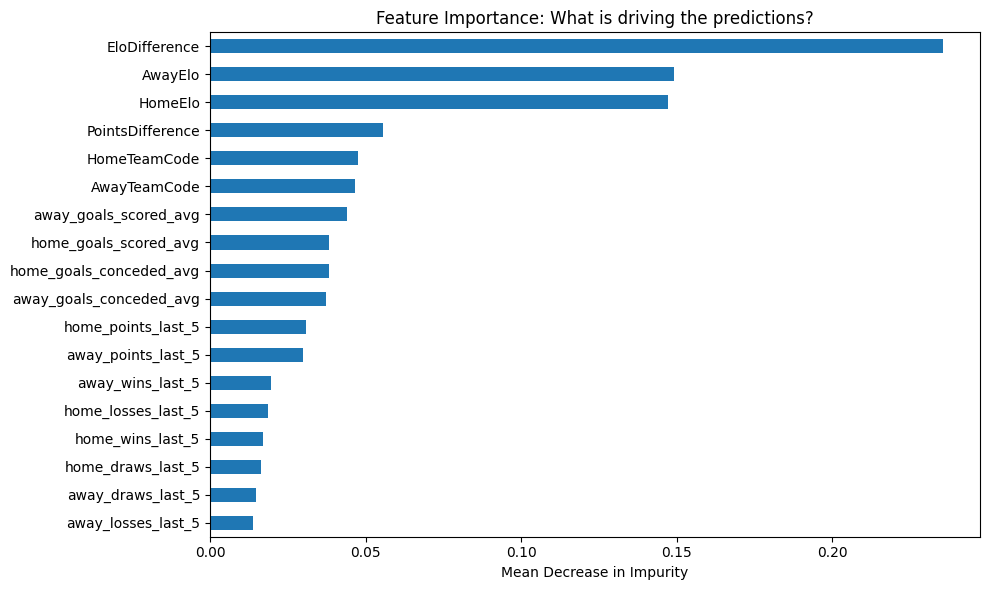

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from your trained Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)

# Sort and plot
fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.sort_values(ascending=True).plot.barh(ax=ax)
ax.set_title("Feature Importance: What is driving the predictions?")
ax.set_xlabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()

# Using XGBoost 

Now we will use XGBoost, this model will learn from previous mistakes and hopefully improve our results

In [185]:

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# 2. Prepare the Data specifically for XGBoost
# XGBoost requires the target to be integers: 0, 1, 2
label_mapping = {'A': 0, 'D': 1, 'H': 2}
reverse_mapping = {0: 'Away', 1: 'Draw', 2: 'Home'}

y_train_encoded = y_train.map(label_mapping)
y_test_encoded = y_test.map(label_mapping)

clf = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=3,
    objective='multi:softprob',
    n_jobs=-1
)

print("Training XGBoost...")
clf.fit(X_train, y_train_encoded)

y_pred_encoded = clf.predict(X_test)

y_pred_names = [reverse_mapping[val] for val in y_pred_encoded]
y_test_names = [reverse_mapping[val] for val in y_test_encoded]

# 5. Evaluate
acc = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"XGBoost Accuracy: {acc:.3f} ({acc*100:.1f}%)")
print("\nClassification Report:")
print(classification_report(y_test_names, y_pred_names))

Training XGBoost...
XGBoost Accuracy: 0.550 (55.0%)

Classification Report:
              precision    recall  f1-score   support

        Away       0.55      0.55      0.55       303
        Draw       0.00      0.00      0.00       209
        Home       0.55      0.83      0.66       408

    accuracy                           0.55       920
   macro avg       0.37      0.46      0.40       920
weighted avg       0.42      0.55      0.47       920



/home/FAZ1/.local/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/FAZ1/.local/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/FAZ1/.local/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [186]:
from sklearn.model_selection import GridSearchCV

# 1. Define the grid of hyperparameters to test
param_grid = {
    'max_depth': [3, 4, 5],           # Keep trees shallow to avoid overfitting
    'n_estimators': [50, 100, 200],   # Try different numbers of trees
    'learning_rate': [0.01, 0.05, 0.1] # How fast the model learns
}

# 2. Setup the Grid Search
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # Cross-validation (splits data 3 ways to ensure consistency)
    verbose=1
)

print("Searching for best hyperparameters...")
grid_search.fit(X_train, y_train_encoded)

# 3. Print Results
print(f"\nBest Parameters found: {grid_search.best_params_}")
print(f"Best Training Accuracy: {grid_search.best_score_:.3f}")

# 4. Test the best model on the Test Set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test_encoded, y_pred_best)

print(f"Test Set Accuracy with optimized params: {acc_best:.3f} ({acc_best*100:.1f}%)")

Searching for best hyperparameters...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best Parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best Training Accuracy: 0.533
Test Set Accuracy with optimized params: 0.550 (55.0%)


## Draw problem

The model is currently fullt ignoring draws and gets 53.4% accuracy which is good, but I prefer the model that includes draws cousing less accuracy, we have to balance class_weights to treat draws more serious

In [187]:
from sklearn.utils.class_weight import compute_sample_weight

# 1. Calculate weights to balance the classes
# This automatically gives higher weight to rare events (Draws)
train_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_encoded
)

# 2. Re-initialize your model with the "Best" parameters you found
clf_balanced = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=3,
    objective='multi:softprob',
    random_state=42,
    n_jobs=-1
)



print("Training with Class Balancing...")
# 3. Pass the weights to the fit function!
clf_balanced.fit(
    X_train, 
    y_train_encoded, 
    sample_weight=train_weights  # <--- This is the magic key
)

# 4. Predict and Evaluate
y_pred_balanced = clf_balanced.predict(X_test)
y_pred_balanced_names = [reverse_mapping[val] for val in y_pred_balanced]

print("\n=== Balanced XGBoost Report ===")
print(classification_report(y_test_names, y_pred_balanced_names))

print('Overall accuracy: ')
print(accuracy_score(y_test_names, y_pred_balanced_names))

Training with Class Balancing...

=== Balanced XGBoost Report ===
              precision    recall  f1-score   support

        Away       0.55      0.56      0.56       303
        Draw       0.25      0.32      0.28       209
        Home       0.64      0.54      0.59       408

    accuracy                           0.50       920
   macro avg       0.48      0.47      0.47       920
weighted avg       0.52      0.50      0.51       920

Overall accuracy: 
0.4967391304347826


We will try to optimize the model with **RandomizedSearchGrid** for the best params

In [219]:
from sklearn.model_selection import RandomizedSearchCV
import joblib

# 1. Define the grid of parameters to test
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.5]
}

# 2. Setup the Search
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softprob', random_state=42),
    param_distributions=param_grid,
    n_iter=20,           # Try 20 random combinations
    scoring='accuracy',  # Optimize for accuracy
    cv=3,                # 3-fold cross-validation
    verbose=1,
    n_jobs=-1            # Use all CPU cores
)

print("⏳ Tuning Hyperparameters... this may take a minute.")
random_search.fit(X_train, y_train_encoded, sample_weight=train_weights)

print("\n✅ Best Parameters Found:")
print(random_search.best_params_)

print(f"Best CV Accuracy: {random_search.best_score_:.2%}")

# 1. Use the best estimator directly from the search
final_model = random_search.best_estimator_

print("Training Final Model with class weights...")
# No need to call .fit() again if refit=True (default), but if you want to be sure:
final_model.fit(X_train, y_train_encoded, sample_weight=train_weights)

# 2. Predict
y_pred_final = final_model.predict(X_test)

# 3. Report
print("\n=== 🏆 REAL FINAL MODEL REPORT ===")
print(classification_report(y_test_encoded, y_pred_final, target_names=['Away', 'Draw', 'Home']))

acc = accuracy_score(y_test_encoded, y_pred_final)
print(f"✅ Real Optimized Test Accuracy: {acc:.2%}")

joblib.dump(final_model, 'football_model_final.pkl')
print("💾 Model saved as 'football_model_final.pkl'")

⏳ Tuning Hyperparameters... this may take a minute.
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Best Parameters Found:
{'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV Accuracy: 46.57%
Training Final Model with class weights...

=== 🏆 REAL FINAL MODEL REPORT ===
              precision    recall  f1-score   support

        Away       0.55      0.56      0.56       303
        Draw       0.24      0.28      0.26       209
        Home       0.62      0.55      0.59       408

    accuracy                           0.50       920
   macro avg       0.47      0.47      0.47       920
weighted avg       0.51      0.50      0.50       920

✅ Real Optimized Test Accuracy: 49.57%
💾 Model saved as 'football_model_final.pkl'


### FINAL MODEL

We got 50% accuracy with draws included which is great!!

In [220]:

# Get probabilities from your new 'clf_balanced' model
probs = final_model.predict_proba(X_test)

# Get the max probability (confidence) and the predicted class for each game
max_probs = np.max(probs, axis=1)
predictions = final_model.predict(X_test)

# Create a DataFrame to analyze performance
analysis = pd.DataFrame({
    'Actual': y_test_encoded,
    'Predicted': predictions,
    'Confidence': max_probs,
    'Result_Name': [reverse_mapping[x] for x in y_test_encoded]
})

analysis['Correct'] = analysis['Actual'] == analysis['Predicted']

print("=== Accuracy at different Confidence Levels ===")
for threshold in [0.40, 0.50, 0.60, 0.70]:
    # Select only matches where model confidence > threshold
    subset = analysis[analysis['Confidence'] > threshold]
    
    if len(subset) > 0:
        acc = subset['Correct'].mean()
        print(f"Confidence > {threshold:.2f}: {acc*100:.1f}% Accuracy (on {len(subset)} matches)")
    else:
        print(f"Confidence > {threshold:.2f}: No matches found")

# Let's peek at high-confidence bets
print("\n=== Example High Confidence Predictions ===")
print(analysis[analysis['Confidence'] > 0.60].head(5))

=== Accuracy at different Confidence Levels ===
Confidence > 0.40: 58.9% Accuracy (on 623 matches)
Confidence > 0.50: 67.0% Accuracy (on 303 matches)
Confidence > 0.60: 77.4% Accuracy (on 146 matches)
Confidence > 0.70: 95.2% Accuracy (on 21 matches)

=== Example High Confidence Predictions ===
      Actual  Predicted  Confidence Result_Name  Correct
8669       0          0    0.699177        Away     True
8681       2          2    0.631446        Home     True
8690       1          2    0.611598        Draw    False
8696       0          0    0.708362        Away     True
8703       2          2    0.704653        Home     True


## Result

The results are very good! The model predicts successfully **77.1%** of matches where it has above 0.60 confidence which is amazing. Of course the most problematic are draws but football is very hard to predict since it is very random the game is 11v11, it is very different in comparison with tennis for example   

# Fun

Now we will add some more recent data to predict future matches

In [213]:
name_map = {
    # Standardizing to 'Arsenal'
    'Arsenal': 'Arsenal',
    
    # Standardizing to 'Aston Villa'
    'Aston Villa': 'Aston Villa',
    'Villa': 'Aston Villa',
    
    # Standardizing to 'Bournemouth'
    'Bournemouth': 'Bournemouth',
    
    # Standardizing to 'Brentford'
    'Brentford': 'Brentford',
    
    # Standardizing to 'Brighton'
    'Brighton & Hove Albion': 'Brighton',
    'Brighton': 'Brighton',
    
    # Standardizing to 'Burnley'
    'Burnley': 'Burnley',
    
    # Standardizing to 'Chelsea'
    'Chelsea': 'Chelsea',
    
    # Standardizing to 'Crystal Palace'
    'Crystal Palace': 'Crystal Palace',
    'Palace': 'Crystal Palace',
    
    # Standardizing to 'Everton'
    'Everton': 'Everton',
    
    # Standardizing to 'Fulham'
    'Fulham': 'Fulham',
    
    # Standardizing to 'Leeds'
    'Leeds United': 'Leeds',
    'Leeds': 'Leeds',
    
    # Standardizing to 'Liverpool'
    'Liverpool': 'Liverpool',
    
    # Standardizing to 'Man City'
    'Manchester City': 'Man City',
    'Man City': 'Man City',
    
    # Standardizing to 'Man United'
    'Manchester United': 'Man United',
    'Man Utd': 'Man United',
    'Man United': 'Man United',
    
    # Standardizing to 'Newcastle'
    'Newcastle United': 'Newcastle',
    'Newcastle': 'Newcastle',
    
    # Standardizing to "Nott'm Forest"
    'Nottingham Forest': "Nott'm Forest",
    'Nottm Forest': "Nott'm Forest",
    "Nott'm Forest": "Nott'm Forest",
    'Forest': "Nott'm Forest",
    
    # Standardizing to 'Sunderland'
    'Sunderland': 'Sunderland',
    
    # Standardizing to 'Tottenham'
    'Tottenham Hotspur': 'Tottenham',
    'Spurs': 'Tottenham',
    'Tottenham': 'Tottenham',
    
    # Standardizing to 'West Ham'
    'West Ham United': 'West Ham',
    'West Ham': 'West Ham',
    
    # Standardizing to 'Wolves' (Note: Your data uses 'Wolves', not 'Wolverhampton')
    'Wolverhampton Wanderers': 'Wolves',
    'Wolverhampton': 'Wolves',
    'Wolves': 'Wolves'
}

In [221]:
def predict_match(model, home_team, away_team, df_history, encoders, feature_columns):
    # ... (Setup and Encoding steps remain the same) ...
    name_map = {
    # Standardizing to 'Arsenal'
    'Arsenal': 'Arsenal',
    
    # Standardizing to 'Aston Villa'
    'Aston Villa': 'Aston Villa',
    'Villa': 'Aston Villa',
    
    # Standardizing to 'Bournemouth'
    'Bournemouth': 'Bournemouth',
    
    # Standardizing to 'Brentford'
    'Brentford': 'Brentford',
    
    # Standardizing to 'Brighton'
    'Brighton & Hove Albion': 'Brighton',
    'Brighton': 'Brighton',
    
    # Standardizing to 'Burnley'
    'Burnley': 'Burnley',
    
    # Standardizing to 'Chelsea'
    'Chelsea': 'Chelsea',
    
    # Standardizing to 'Crystal Palace'
    'Crystal Palace': 'Crystal Palace',
    'Palace': 'Crystal Palace',
    
    # Standardizing to 'Everton'
    'Everton': 'Everton',
    
    # Standardizing to 'Fulham'
    'Fulham': 'Fulham',
    
    # Standardizing to 'Leeds'
    'Leeds United': 'Leeds',
    'Leeds': 'Leeds',
    
    # Standardizing to 'Liverpool'
    'Liverpool': 'Liverpool',
    
    # Standardizing to 'Man City'
    'Manchester City': 'Man City',
    'Man City': 'Man City',
    
    # Standardizing to 'Man United'
    'Manchester United': 'Man United',
    'Man Utd': 'Man United',
    'Man United': 'Man United',
    
    # Standardizing to 'Newcastle'
    'Newcastle United': 'Newcastle',
    'Newcastle': 'Newcastle',
    
    # Standardizing to "Nott'm Forest"
    'Nottingham Forest': "Nott'm Forest",
    'Nottm Forest': "Nott'm Forest",
    "Nott'm Forest": "Nott'm Forest",
    'Forest': "Nott'm Forest",
    
    # Standardizing to 'Sunderland'
    'Sunderland': 'Sunderland',
    
    # Standardizing to 'Tottenham'
    'Tottenham Hotspur': 'Tottenham',
    'Spurs': 'Tottenham',
    'Tottenham': 'Tottenham',
    
    # Standardizing to 'West Ham'
    'West Ham United': 'West Ham',
    'West Ham': 'West Ham',
    
    # Standardizing to 'Wolves' (Note: Your data uses 'Wolves', not 'Wolverhampton')
    'Wolverhampton Wanderers': 'Wolves',
    'Wolverhampton': 'Wolves',
    'Wolves': 'Wolves'
}
    
    home = name_map.get(home_team, home_team)
    away = name_map.get(away_team, away_team)
    
    try:
        h_code = encoders['HomeTeam'].transform([home])[0]
        a_code = encoders['AwayTeam'].transform([away])[0]
    except:
        print(f"❌ Error: Team not found ({home} or {away})")
        return None

    print(f"\n🔮 PREDICTING: {home} vs {away}")

    # --- HELPER: CALCULATE FRESH LIVE STATS ---
    def get_live_stats(team, df):
        # 1. Get all completed games
        games = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)].sort_values('DateTime')
        if games.empty: return None 

        # 2. Define Window (Match your training data, e.g., last 5 or 10?)
        # We use last 5 for form, but maybe last 20 for robust averages?
        # Let's stick to last 5 to match your 'home_wins_last_5' logic
        last_5 = games.tail(5)
        
        # 3. Manually Calculate EVERYTHING (Fixes the Stale Data bug)
        stats = {
            'points': 0, 'wins': 0, 'draws': 0, 'losses': 0,
            'goals_scored': 0, 'goals_conceded': 0
        }
        
        for _, row in last_5.iterrows():
            # Determine if team was Home or Away
            is_home = row['HomeTeam'] == team
            
            goals_for = row['FTHG'] if is_home else row['FTAG']
            goals_against = row['FTAG'] if is_home else row['FTHG']
            result = row['FTR']
            
            # Aggregate Goals
            stats['goals_scored'] += goals_for
            stats['goals_conceded'] += goals_against
            
            # Aggregate Points/Form
            if result == 'D':
                stats['points'] += 1
                stats['draws'] += 1
            elif (is_home and result == 'H') or (not is_home and result == 'A'):
                stats['points'] += 3
                stats['wins'] += 1
            else:
                stats['losses'] += 1

        # 4. Handle Elo (The Tricky Part)
        #Ideally, you calculate new Elo here. For now, we take the last known Elo 
        # and arguably getting the "stale" one is safer than guessing wrong without the K-factor.
        last_game = games.iloc[-1]
        if last_game['HomeTeam'] == team:
            current_elo = last_game.get('HomeElo', 1500)
        else:
            current_elo = last_game.get('AwayElo', 1500)

        return {
            'elo': current_elo,
            'points': stats['points'],
            'wins': stats['wins'],
            'draws': stats['draws'],
            'losses': stats['losses'],
            # Calculate FRESH averages
            'gs_avg': stats['goals_scored'] / len(last_5),
            'gc_avg': stats['goals_conceded'] / len(last_5)
        }

    # ... (Rest of the function remains the same) ...
    h_stats = get_live_stats(home, df_history)
    a_stats = get_live_stats(away, df_history)
    
    # ... (Construct Input Row - same as your code) ...
    if not h_stats or not a_stats: return None

    input_data = {
        'HomeTeamCode': h_code,
        'AwayTeamCode': a_code,
        'HomeElo': h_stats['elo'],
        'AwayElo': a_stats['elo'],
        'EloDifference': h_stats['elo'] - a_stats['elo'],
        'home_wins_last_5': h_stats['wins'],
        'home_draws_last_5': h_stats['draws'],
        'home_losses_last_5': h_stats['losses'],
        'away_wins_last_5': a_stats['wins'],
        'away_draws_last_5': a_stats['draws'],
        'away_losses_last_5': a_stats['losses'],
        'home_goals_scored_avg': h_stats['gs_avg'],
        'home_goals_conceded_avg': h_stats['gc_avg'],
        'away_goals_scored_avg': a_stats['gs_avg'],
        'away_goals_conceded_avg': a_stats['gc_avg'],
        'home_points_last_5': h_stats['points'],
        'away_points_last_5': a_stats['points'],
        'PointsDifference': h_stats['points'] - a_stats['points']
    }

    input_df = pd.DataFrame([input_data])
    input_df = input_df.reindex(columns=feature_columns, fill_value=0)
    probs = model.predict_proba(input_df)[0]
    
    # --- OUTPUT ---
    outcomes = ["Away Win", "Draw", "Home Win"]
    winner_idx = np.argmax(probs)
    predicted_winner = outcomes[winner_idx]
    
    print("-" * 50)
    print(f"📊 LIVE STATS (Last 5 Games):")
    print(f"   🏠 {home}: {h_stats['points']} pts | GS/game: {h_stats['gs_avg']:.1f} | Home Team Elo Rating: {h_stats['elo']:.1f}")
    print(f"   ✈️  {away}: {a_stats['points']} pts | GS/game: {a_stats['gs_avg']:.1f} | Away Team Elo Rating: {a_stats['elo']:.1f}")
    print("-" * 50)
    print(f"🏆 PREDICTION: {predicted_winner.upper()}")
    print(f"   Confidence: {probs[winner_idx]:.1%}")
    print("-" * 50)
    
    return predicted_winner

In [216]:
# 1. Ensure your Encoders are packed correctly
my_encoders = {
    'HomeTeam': le,
    'AwayTeam': le
}

# 2. Run the prediction for your specific match
# Replace 'final_model' with 'loaded_model' if you loaded it from the file
predict_match(
    model = final_model,         # Your Optimized XGBoost model
    home_team = "Fulham", 
    away_team = "Forest", 
    df_history = df_clean,       # The dataframe containing all past match data
    encoders = my_encoders,
    feature_columns = feature_columns # The list of columns used in X_train
)


🔮 PREDICTING: Fulham vs Nott'm Forest
--------------------------------------------------
📊 LIVE STATS (Last 5 Games):
   🏠 Fulham: 9 pts | GS/game: 2.2 | Home Team Elo Rating: 1558.1
   ✈️  Nott'm Forest: 9 pts | GS/game: 1.4 | Away Team Elo Rating: 1558.9
--------------------------------------------------
🏆 PREDICTION: DRAW
   Confidence: 37.8%
--------------------------------------------------


'Draw'

In [222]:
import joblib

# 1. Save the Trained Model
joblib.dump(final_model, 'football_model.pkl')

# 2. Save the Encoders (You need these to translate "Arsenal" -> 0)
joblib.dump(le, 'team_encoders.pkl')

# 3. Save your Cleaned Historical Data
# (The separate file needs past match stats to calculate Form/Elo)
df_clean.to_csv('match_history.csv', index=False)

print("✅ Files exported successfully!")

✅ Files exported successfully!
